In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph
import skimage.filters as filters
import skimage.exposure as exposure
from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature
import skimage.segmentation as seg
import os
from skimage import color, graph, measure

In [2]:
def crop_image_from_gray(img,tol=7):
  if img.ndim ==2:
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]
  elif img.ndim==3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img>tol        
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
        return img
    else:
      img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
      img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
      img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
      img = np.stack([img1,img2,img3],axis=-1)
      return img

def circle_crop_v2(img):
  img = crop_image_from_gray(img)

  height, width, depth = img.shape
  largest_side = np.max((height, width))
  img = cv2.resize(img, (largest_side, largest_side))

  height, width, depth = img.shape

  x = int(width / 2)
  y = int(height / 2)
  r = np.amin((x, y))

  circle_img = np.zeros((height, width), np.uint8)
  cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
  img = cv2.bitwise_and(img, img, mask=circle_img)
  img = crop_image_from_gray(img)

  return img

In [3]:
def glcm(img):
  glcm_feature = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
  distance = [5]
  angles = [0]
  level = 256
  symetric = True
  normed = True

  glcm = graycomatrix(img, distance, angles, level, symmetric=symetric, normed=normed)
  glcm_props = [property for name in glcm_feature for property in graycoprops(glcm, name)[0]]

  return glcm_props

In [5]:
def processing(img):
  # get green channel
  green = img[:,:,1]
  incomplement = cv2.bitwise_not(green) # negative image
  clache = cv2.createCLAHE(clipLimit=5) # Contrast Limited Adaptive Histogram Equalization
  cl1 = clache.apply(incomplement) # Apply CLAHE
  # mopopen = morph.opening(cl1, morph.disk(8, dtype=np.uint8)) # Morphological opening with disk kernel of radius 8
  # godisk = cl1 - mopopen #remove optical disk
  # medfilt = filters.median(godisk) # Median filter
  # background = morph.opening(medfilt, morph.disk(15, dtype=np.uint8)) #get background
  # rmBack = medfilt - background #remove background
  # v_min, v_max = np.percentile(rmBack, (0.2, 99.8)) #get 0.2% and 99.8% percentile
  # better_contrast = exposure.rescale_intensity(rmBack, in_range=(v_min, v_max)) #rescale intensity
  # ret, thresh = cv2.threshold(better_contrast, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) #Otsu thresholding
  # rmSmall = morph.remove_small_objects(thresh, min_size=50, connectivity=1, in_place=False) #remove small objects

  return cl1

In [4]:
def vessel(img):
  retina = color.rgb2gray(img)
  t0, t1 = filters.threshold_multiotsu(retina, classes=3)
  mask = (retina > t0)
  vessels = filters.sato(retina, sigmas=range(1, 10)) * mask
  thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)
  return thresholded

In [9]:
def processing2(img):
  # convert to double
  # img = img.astype(np.float64)
  # convert to lab
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  # concatenate lab
  lab = np.concatenate(3, 1,0,0)
  # element-wise binary operation
  lab = np.bitwise_and(lab[:,:,0], lab[:,:,1])
  lab = np.bitwise_and(lab, lab[:,:,2])
  return lab

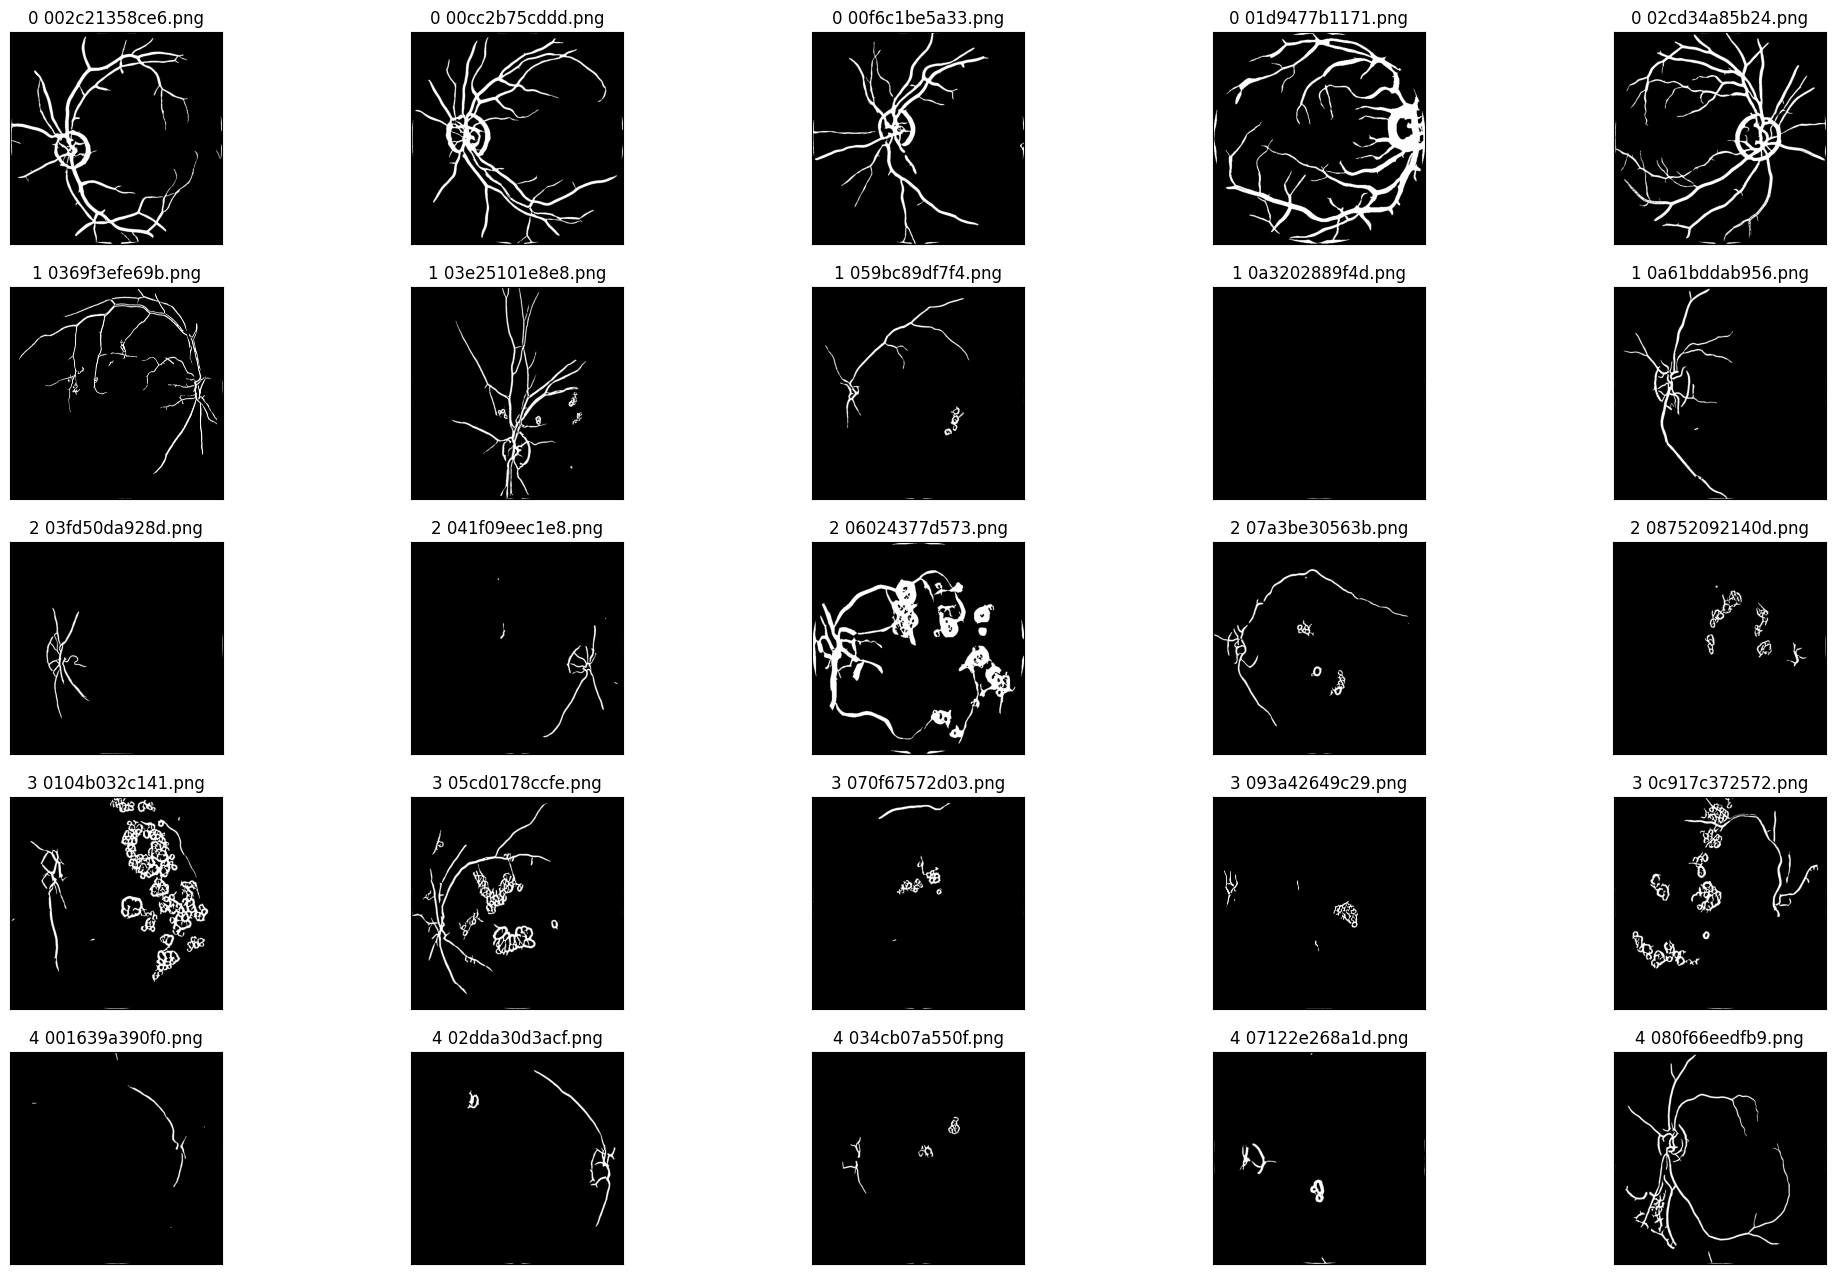

In [5]:
path_dataset = 'E:/Pawang Code/Diabetic Retinopathy/dataset_filter'
fig = plt.figure(figsize=(25, 16))
j= 0
# temp = []
for folder in os.listdir(path_dataset):
    sub_folder_files = os.listdir(os.path.join(path_dataset, folder))
    for i, filename in enumerate(sub_folder_files):
        ax = fig.add_subplot(5, 5, j+1, xticks=[], yticks=[])
        img = cv2.imread(os.path.join(path_dataset, folder, filename))
        img = circle_crop_v2(img)
        img = vessel(img)
        plt.imshow(img, cmap='gray')
        ax.set_title(folder + ' ' + filename)
        # temp.append(glcm(img))
        j += 1
        if i == 4:
            break

In [20]:
print(temp)

[[68.63225779967159, 3.8437009669768285, 0.40063468101322347, 0.0434871146371331, 0.20853564356515433, 0.978156538231189], [69.2915452267031, 3.8376960583276367, 0.40941167237510484, 0.04391441227688618, 0.20955765859754727, 0.973130327163396], [66.44609469074986, 3.711183178252144, 0.40345579804218146, 0.04375202895351511, 0.20916985670386426, 0.973195877179464], [170.72844964629206, 5.521556977452772, 0.3763402156770934, 0.04145554597805548, 0.20360635053469103, 0.9392224241753901], [74.57445614035085, 4.450586466165412, 0.3757467213393012, 0.04358527331107649, 0.20877086317557939, 0.9675668731258124], [72.44644134282063, 3.3541424922459404, 0.42087013931134143, 0.04429482351889785, 0.21046335433727614, 0.9740914244916616], [57.46631271665754, 2.8883889801131177, 0.45789110691894025, 0.04474424754882112, 0.21152836109803602, 0.9756836665764937], [88.6698604269294, 4.413266739646051, 0.378040426812152, 0.043152121841284086, 0.20773088802892092, 0.9790075838811988], [79.90003284072249,